# Cell type differences and effects of interferon stimulation on immune cells

Demonstrating differential expression between cell types and the effect of interferon stimulation within a cell type (CD4 T cells).

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import scanpy.api as sc
import scipy as sp
import itertools
import numpy as np
import scipy.stats as stats
from scipy.integrate import dblquad
import seaborn as sns
from statsmodels.stats.multitest import fdrcorrection
import imp
pd.options.display.max_rows = 999
pd.set_option('display.max_colwidth', -1)
import pickle as pkl
import time

/home/mkim7/anaconda3/envs/single_cell/lib/python3.7/site-packages/scanpy/api/__init__.py:6: FutureWarning: 

In a future version of Scanpy, `scanpy.api` will be removed.
Simply use `import scanpy as sc` and `import scanpy.external as sce` instead.

  FutureWarning


In [42]:
%matplotlib inline

In [12]:
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'figure.titlesize':'xx-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)


In [13]:
import warnings
warnings.filterwarnings('ignore')

In [14]:
from sklearn.decomposition import PCA

In [15]:
from sklearn.preprocessing import StandardScaler

In [16]:
import sys
sys.path.append('/home/mkim7/Github/scrna-parameter-estimation/scmemo')
import scmemo, utils

In [21]:
data_path = '/data/parameter_estimation/interferon_data/20200324/'

### Perform some basic filtering

In [22]:
adata = sc.read(data_path + 'interferon_highcount.raw.h5ad')
adata = adata[:, adata.var.index.map(lambda x: x[:2] != 'HB')]

In [23]:
adata.obs.cell.value_counts()

CD4 T cells          10389
CD14+ Monocytes      5385 
B cells              2573 
CD8 T cells          2042 
NK cells             1993 
FCGR3A+ Monocytes    1599 
Dendritic cells      432  
Megakaryocytes       260  
Name: cell, dtype: int64

In [24]:
adata.obs['cell_type'] = (adata.obs['cell'].astype(str) + ' - ' + adata.obs['stim'].astype(str)).astype('category')

Trying to set attribute `.obs` of view, making a copy.


In [25]:
sc.pl.tsne(adata, color='cell_type')

In [26]:
# plt.figure(figsize=(5, 3))
# sns.boxplot(x='n_counts', y='cell_type', data=adata.obs)
# plt.title('Total UMI counts by cell type')
# plt.savefig('celltype_numi.pdf')
# plt.savefig('celltype_numi.png')

In [27]:
print('Number of genes kept:', adata.shape[1])

Number of genes kept: 3593


### DE, DV results

In [28]:
with open(data_path + 'stim_effect_1d_params.pkl', 'rb') as f:
    parameter_dict = pkl.load(f)
with open(data_path + 'stim_effect_ci_1d.pkl', 'rb') as f:
    ci_dict = pkl.load(f)
with open(data_path + 'stim_effect_1d.pkl', 'rb') as f:
    test_dict = pkl.load(f)

In [312]:
def get_key(ct):
    return (ct + ' - ctrl', ct + ' - stim')

def create_1d_df(adata, ct, test_dict):
    
    df = pd.DataFrame()
    gene_list = adata.var.index
    df['gene'] = gene_list
    df['ct'] = ct
    
    for key,val in test_dict[get_key(ct)].items():
        df[key] = val
        
    return df

def get_data(ct, gene_idx):
    
    return\
        (adata[adata.obs.cell_type == (ct + ' - ctrl'), :][:, gene_idx].X,
        adata[adata.obs.cell_type == (ct + ' - stim'), :][:, gene_idx].X)

def plot_ctrl_stim_expr(ct, gene_idx, method='mpl', log=False):
    
    unique_counts_ctrl = np.unique(adata[adata.obs.cell_type == (ct + ' - ctrl'), :][:, gene_idx].X).shape[0]
    unique_counts_stim = np.unique(adata[adata.obs.cell_type == (ct + ' - stim'), :][:, gene_idx].X).shape[0]

    if method == 'mpl':
        plt.hist(
            [
                adata[adata.obs.cell_type == (ct + ' - ctrl'), :][:, gene_idx].X,
                adata[adata.obs.cell_type == (ct + ' - stim'), :][:, gene_idx].X,
            ], log=log)
    else:
        sns.distplot(adata[adata.obs.cell_type == (ct + ' - ctrl'), :][:, gene_idx].X, log=log)
        sns.distplot(adata[adata.obs.cell_type == (ct + ' - stim'), :][:, gene_idx].X, log=log)

def violin_plot(ct, gene_idx):
    
    sns.violinplot(
        [adata[adata.obs.cell_type == (ct + ' - ctrl'), :][:, gene_idx].X, 
         adata[adata.obs.cell_type == (ct + ' - stim'), :][:, gene_idx].X])

In [193]:
cts = ['CD4 T cells',  'CD14+ Monocytes', 'FCGR3A+ Monocytes', 'NK cells','CD8 T cells', 'B cells']
df = pd.concat([create_1d_df(adata, ct, test_dict) for ct in cts])

In [395]:
candidates = df\
    .query('de_fdr > 0.2')\
    .query('dv_fdr < 0.1')\
    .sort_values('log_mean_1', ascending=False)\
    .head(30)

In [ ]:
for idx, row in candidates.iterrows():
    ct = row['ct']
    gene_idx = idx
    plt.figure(figsize=(2, 1))
    
    ctrl_data, stim_data = get_data(ct, gene_idx)
    plt.hist([ctrl_data, stim_data], log=False, bins=15);
    plt.title(ct + ' ' + adata.var.index[gene_idx])

In [415]:
ct = 'CD8 T cells'
#ct = 'NK cells'
ct = 'FCGR3A+ Monocytes'
#ct = 'B cells'
#ct = 'CD4 T cells'
gene = 240

In [400]:
ctrl_data, stim_data = get_data(ct, gene_idx)

In [ ]:
ctrl_counts = 

In [ ]:
plt.hist(
    [ctrl_data, stim_data], 
    log=False, 
    bins=15, 
    density=True, 
    histtype='step');

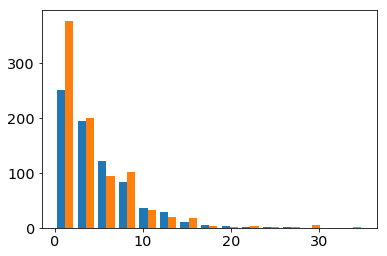

In [416]:
plt.hist(
    [ctrl_data, stim_data], 
    log=False, 
    bins=15);

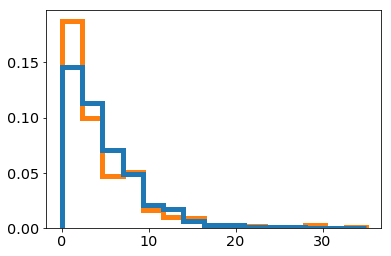

In [413]:
plt.hist(
    [ctrl_data, stim_data], 
    log=False, 
    bins=15, 
    density=True, 
    histtype='step',
    lw=5,
    fill=False);

### Some IFITs

In [404]:
ct = 'CD4 T cells'

In [ ]:
inc_var_genes = 

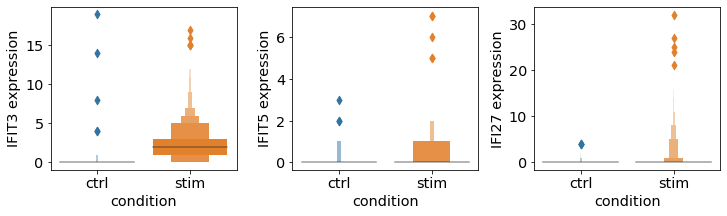

In [219]:
plt.figure(figsize=(12, 3));
plt.subplots_adjust(wspace=0.3)
plt.subplot(1, 3, 1);
plot_ct_specific_exp(adata, 'IFIT3', 'CD4 T cells')
plt.subplot(1, 3, 2);
plot_ct_specific_exp(adata, 'IFIT5', 'CD4 T cells')
plt.subplot(1, 3, 3);
plot_ct_specific_exp(adata, 'IFI27', 'CD4 T cells')
plt.savefig(data_path + 'figures/CD4_DV_genes.pdf', bbox_inches='tight')
plt.savefig(data_path + 'figures/CD4_DV_genes.png', bbox_inches='tight')